# Capacitated Green Vehicle Routing Problem

<img src="http://neo.lcc.uma.es/dynamic/images/vrp.png" width="400" />

- $n$ is the number of clientes
- $N$ is set of clients, with $N=\{1,2,...,n\}$
- $V$ is set of vetices (or nodes), with $V=\{0\}\cup N$
- $A$ is set of arcs, with $A=\{(i,j)\in V^2 : i\neq j\}$
- $c_{ij}$ is cost of travel over arc $(i,j)\in A$
- $Q$ is the vehicle capacity
- $q_i$ is the amount that has to be delivered to customer $i\in N$

Then, the formulation is the following
$$\begin{align}
\min \quad & \sum_{i,j\in A} c_{ij} x_{ij} \\
\text{s.t.} \quad & \sum_{j\in V , j\neq i} x_{ij} = 1  && i \in N \\
& \sum_{i\in V , i\neq j} x_{ij} = 1 && j \in N \\
& \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
& q_i \leq u_i \leq Q && i \in N \\
& x_{ij} \in \{0,1\} && i,j \in A
\end{align}$$

In [1]:
# Importing needed libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum # you need to install gurobi for your platform (https://www.gurobi.com/)

In [34]:
sns.set_style("darkgrid")
sns.set_context("paper")

<Figure size 14400x14400 with 0 Axes>

<Figure size 14400x14400 with 0 Axes>

In [3]:
# Creating our random number generator with a seed of 2 to ensure it always remains the same.
rnd = np.random
rnd.seed(2)

In [4]:
n = 20  # numbre of clients
xc = rnd.rand(n+1)*200
yc = rnd.rand(n+1)*100

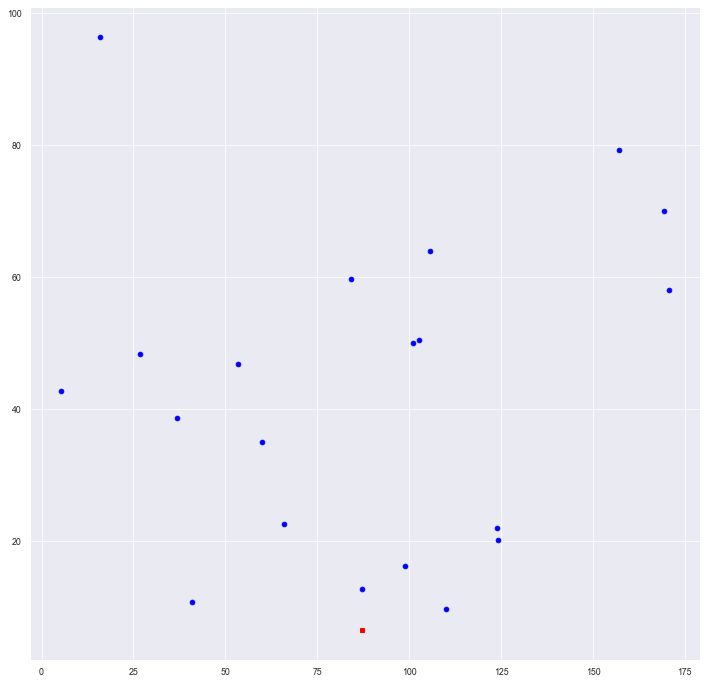

In [41]:
# initial plot of customers and depot
plt.figure(figsize=(12,12))
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

In [6]:
"""
    Considering our problem as TSP  and declaring general variables,
    To be honest all we need are the distances in `c` but we list all
    for easy readability
"""
N = [i for i in range(1, n+1)]
V = [0] + N
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
Q = 20
q = {i: rnd.randint(1, 10) for i in N}

In [7]:
# setting threshold distance of Green Vehicle
ev_threshold = 200
allowed_travel_distance = ev_threshold/2

In [8]:
# Computing shortest distance for Green Vehicle i.e Vehicle Range and region
import collections


c_cv = c.copy()
od = collections.OrderedDict(sorted(c_cv.items()))
route = {}
for index, arc in  enumerate(od):
    from_depot = {x: c_cv[x] for x in c_cv if x[0] == index}
    if from_depot:
        path = min(from_depot, key=from_depot.get)
        index += path[1]
        if sum(route.values()) < allowed_travel_distance:
            route[path] = c_cv[path]
            _ = c_cv.pop((path[1],path[0]), None)
            _ = c_cv.pop((path[0],path[1]), None)

In [9]:
# Creating Base Variables for Electric Vehicles


c_ev_1 = {r: route[r] for r in route}
c_ev_2 = {(r[1],r[0]): route[r] for r in route}
c_ev = {**c_ev_1, **c_ev_2}

ev = list(set(y for x in list(c_ev.keys()) for y in x))
N_ev = ev[1:]
V_ev =  ev
A_ev = [(i, j) for i in V_ev for j in V_ev if i != j]
c_ev = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A_ev}
Q_ev = 20
q_ev = {i: rnd.randint(1, 10) for i in N_ev}

In [10]:
# Creating Base Variables for Conventional Vehicles


cv = list(set(y for x in list(c_cv.keys()) for y in x)) 
cv = [x for x in cv if x not in ev]

N_cv = cv
V_cv =  [0] + cv
A_cv = [(i, j) for i in V_cv for j in V_cv if i != j]
c_cv = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A_cv}
Q_cv = 20
q_cv = {i: rnd.randint(1, 10) for i in N_cv}

## Conventional Vehicles

In [11]:
# Conventional Vehicle Model Creation


mdC = Model('CVRP')
x_cv = mdC.addVars(A_cv, vtype=GRB.BINARY)
u_cv = mdC.addVars(N_cv, vtype=GRB.CONTINUOUS)
mdC.modelSense = GRB.MINIMIZE
mdC.setObjective(quicksum(x_cv[i, j]*c_cv[i, j] for i, j in A_cv))

Using license file /Users/larry/gurobi.lic
Academic license - for non-commercial use only


In [12]:
# Conventional Vehicle Model Constraints


mdC.addConstrs(quicksum(x_cv[i, j] for j in V_cv if j != i) == 1 for i in N_cv)
mdC.addConstrs(quicksum(x_cv[i, j] for i in V_cv if i != j) == 1 for j in N_cv)
mdC.addConstrs((x_cv[i, j] == 1) >> (u_cv[i]+q_cv[j] == u_cv[j])
               for i, j in A_cv if i != 0 and j != 0)
mdC.addConstrs(u_cv[i] >= q[i] for i in N_cv)
mdC.addConstrs(u_cv[i] <= Q_ev for i in N_cv)

{7: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>}

In [13]:
# Conventional Vehicle Model Optimization Parameters


mdC.Params.MIPGap = 0.1
mdC.Params.TimeLimit = 30  # seconds
mdC.optimize()

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 40 rows, 120 columns and 220 nonzeros
Model fingerprint: 0xf0b5c9e5
Model has 90 general constraints
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve added 205 rows and 25 columns
Presolve time: 0.01s
Presolved: 245 rows, 145 columns, 1351 nonzeros
Variable types: 55 continuous, 90 integer (90 binary)

Root relaxation: objective 3.173402e+02, 65 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  317.34016    0   25   

In [14]:
active_arcs = [a for a in A_cv if x_cv[a].x > 0.99]

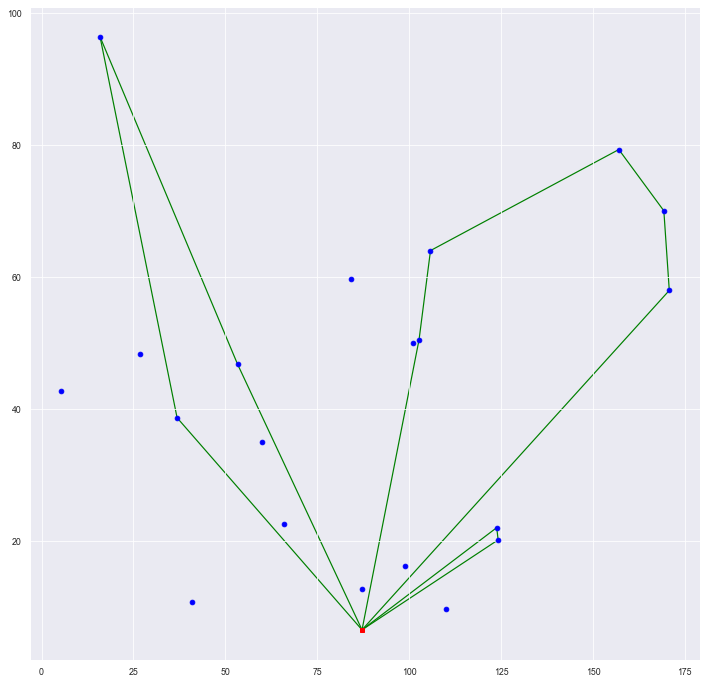

In [44]:
# Conventional Vehicle Model Plot

plt.figure(figsize=(12,12))
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)   
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

##  Electric Vehicles

In [16]:
# Electric Vehicle Model Creation


mdE = Model('CVRP')
x_ev = mdE.addVars(A_ev, vtype=GRB.BINARY)
u_ev = mdE.addVars(N_ev, vtype=GRB.CONTINUOUS)
mdE.modelSense = GRB.MINIMIZE
mdE.setObjective(quicksum(x_ev[i, j]*c_ev[i, j] for i, j in A_ev))

In [17]:
# Electric Vehicle Model Constraints


mdE.addConstrs(quicksum(x_ev[i, j] for j in V_ev if j != i) == 1 for i in N_ev)
mdE.addConstrs(quicksum(x_ev[i, j] for i in V_ev if i != j) == 1 for j in N_ev)
mdE.addConstrs((x_ev[i, j] == 1) >> (u_ev[i]+q_ev[j] == u_ev[j])
               for i, j in A_ev if i != 0 and j != 0)
mdE.addConstrs(u_ev[i] >= q_ev[i] for i in N_ev)
mdE.addConstrs(u_ev[i] <= Q_ev for i in N_ev)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>}

In [18]:
# Electric Vehicle Model Optimization Parameters


mdE.Params.MIPGap = 0.1
mdE.Params.TimeLimit = 30  # seconds
mdE.optimize()

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 40 rows, 120 columns and 220 nonzeros
Model fingerprint: 0xa13b4de2
Model has 90 general constraints
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve added 205 rows and 25 columns
Presolve time: 0.01s
Presolved: 245 rows, 145 columns, 1357 nonzeros
Variable types: 55 continuous, 90 integer (90 binary)

Root relaxation: objective 2.597743e+02, 60 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  259.77427    0   25   

In [19]:
active_arcs_electric_route = [a for a in A_ev if x_ev[a].x > 0.99]

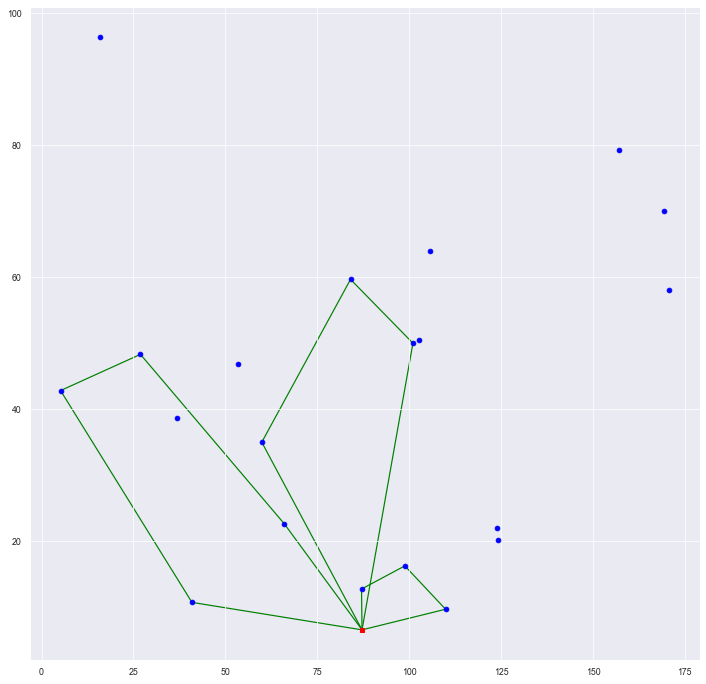

In [45]:
# Electric Vehicle Model Plot

plt.figure(figsize=(12,12))
for i, j in active_arcs_electric_route:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')